понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

# Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

# Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

# Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

# CNN для обработки текстов



In [1]:
!pip install torchmetrics

In [2]:
!pip install ipdb

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

### Находим фамилии среди слов русского языка



### Скачивание и подготовка данных

In [4]:
!wget -O surnames.txt  "https://drive.google.com/uc?export=download&id=1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5"

--2021-11-22 20:48:59--  https://drive.google.com/uc?export=download&id=1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5
Resolving drive.google.com (drive.google.com)... 172.217.214.100, 172.217.214.139, 172.217.214.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a18gb4m44nsgsn80out30cq1hh489q7f/1637614125000/14571764687846983170/*/1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5?e=download [following]
--2021-11-22 20:49:00--  https://doc-08-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a18gb4m44nsgsn80out30cq1hh489q7f/1637614125000/14571764687846983170/*/1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5?e=download
Resolving doc-08-6k-docs.googleusercontent.com (doc-08-6k-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-08-6k-docs.googleusercontent.com (d

In [5]:
data = pd.read_csv('surnames.txt', encoding='utf-8', sep='\t', header=None,  names=['word','label'])

In [6]:
train_data, val_data = train_test_split(data, test_size=0.2)

In [7]:
train_data[train_data.label == 1].shape[0] /train_data.shape[0]

0.12144121208357912

In [8]:
train_data.head(50)

,word,label
9035,видеокассета,0
9032,видеокартах,0
66634,стужей,0
32053,ЛИДИЯ,0
24413,исправлением,0
44867,очевидцем,0
68942,Тибу,0
63651,снабжении,0
61391,Сдвигу,0
50249,Полозья,0


Теперь нам нужно собрать все символы в словарь. Лучше сразу посчитать количество упоминаний, чтобы отсеять самые редкие.

In [9]:
vocab = Counter()
for symbol in data['word']:
    vocab.update(list(symbol))
print('всего уникальных символов:', len(vocab))

всего уникальных символов: 85


In [10]:
vocab

Counter({'А': 7493,
         'а': 57886,
         'р': 39631,
         'о': 59076,
         'н': 41649,
         'Р': 5636,
         'О': 7225,
         'Н': 5462,
         'е': 54153,
         'в': 23485,
         'х': 6022,
         'б': 8440,
         'к': 26522,
         'ж': 4331,
         'у': 17169,
         'м': 26553,
         'ы': 7465,
         'й': 7297,
         'д': 15510,
         'л': 25494,
         'и': 58252,
         'т': 36412,
         'Б': 2967,
         'Ш': 858,
         'ш': 3678,
         'з': 9072,
         'с': 28097,
         'ю': 4854,
         'г': 8524,
         'ч': 5866,
         'Д': 3385,
         'Л': 3676,
         'п': 15241,
         'Х': 1214,
         'Г': 2395,
         'Е': 5981,
         'У': 2215,
         'В': 4200,
         'Ы': 787,
         'М': 4175,
         'Ж': 720,
         'И': 7304,
         'Ч': 1013,
         'ц': 6590,
         'я': 9339,
         'ь': 7634,
         'К': 5403,
         'Й': 763,
         'Ю': 550,
         '

In [11]:
filtered_vocab = set()

for symbol in vocab:
    if vocab[symbol] > 5:
        filtered_vocab.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных символов, втретившихся больше 5 раз: 70


In [12]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
symbol2id = {'PAD':0}

for symbol in filtered_vocab:
    symbol2id[symbol] = len(symbol2id)

In [13]:
#обратный словарь для того, чтобы раскодировать последовательность
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [14]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE


device(type='cuda')

### Dataset & DataLoader

In [15]:
class SurnamesDataset(Dataset):

    def __init__(self, dataset, symbol2id, DEVICE):
        self.dataset = dataset['word'].values
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['label'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

### создаем итераторы по данным для трейна и теста

In [16]:
train_dataset = SurnamesDataset(train_data, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [17]:
batch = next(iter(train_iterator))

In [18]:
batch[0].shape

torch.Size([1024, 20])

In [19]:
[id2symbol[int(i)] for i in batch[0][0]]

['Н',
 'е',
 'д',
 'е',
 'р',
 'ж',
 'а',
 'н',
 'и',
 'е',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [20]:
batch[1]

tensor([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [21]:
val_dataset = SurnamesDataset(val_data, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [22]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 20])

### CNN model

In [23]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

tensor([[[ 0.1885, -0.1980,  1.3126, -0.1025],
         [ 1.5409,  0.1547, -0.7873, -0.1500],
         [ 0.4081,  0.2194, -0.1682, -0.3834],
         [-0.2095,  0.6825,  2.0395, -0.1677],
         [ 0.3436, -0.9711,  1.0768,  0.5207],
         [ 0.3810,  1.4883,  0.3429, -0.0839],
         [ 0.7323, -3.1354, -1.3049,  0.8909],
         [-0.3939,  0.1204, -0.2567,  0.3816]],

        [[-0.1963, -1.9160, -0.4341,  0.1044],
         [ 0.0375, -0.2647, -0.2494, -0.1921],
         [ 2.4131, -0.1584, -0.5153, -1.0434],
         [ 1.6581,  0.7602,  0.2053,  0.8443],
         [-0.1549, -0.3073,  1.1251, -1.5624],
         [ 0.0067, -0.2508,  0.2348, -0.8780],
         [ 1.8899,  0.2995, -1.1775,  0.5583],
         [-1.4322,  0.8759,  1.9928,  1.8875]],

        [[ 1.4176, -0.8858,  0.2661, -0.4785],
         [-0.2453,  0.2560,  1.6534, -1.2000],
         [-0.5488, -1.5365, -0.1259,  0.0101],
         [-1.9550,  0.6945, -0.9071, -1.5170],
         [ 1.5609,  0.8492, -1.2659,  0.2130],
         

In [24]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

torch.Size([3, 8, 2])


tensor([[[ 0.1885,  1.3126],
         [ 1.5409, -0.1500],
         [ 0.4081, -0.1682],
         [ 0.6825,  2.0395],
         [ 0.3436,  1.0768],
         [ 1.4883,  0.3429],
         [ 0.7323,  0.8909],
         [ 0.1204,  0.3816]],

        [[-0.1963,  0.1044],
         [ 0.0375, -0.1921],
         [ 2.4131, -0.5153],
         [ 1.6581,  0.8443],
         [-0.1549,  1.1251],
         [ 0.0067,  0.2348],
         [ 1.8899,  0.5583],
         [ 0.8759,  1.9928]],

        [[ 1.4176,  0.2661],
         [ 0.2560,  1.6534],
         [-0.5488,  0.0101],
         [ 0.6945, -0.9071],
         [ 1.5609,  0.2130],
         [ 1.7286,  2.0900],
         [ 1.0670,  0.5879],
         [ 1.7755, -0.8158]]])

In [25]:
fm.max(2)[0]

tensor([[1.3126, 1.5409, 0.4081, 2.0395, 1.0768, 1.4883, 0.8909, 0.3816],
        [0.1044, 0.0375, 2.4131, 1.6581, 1.1251, 0.2348, 1.8899, 1.9928],
        [1.4176, 1.6534, 0.0101, 0.6945, 1.5609, 2.0900, 1.0670, 1.7755]])

In [26]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits
      
        
    

In [27]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[ 2, 50, 15,  ...,  0,  0,  0],
        [ 1, 47, 24,  ...,  0,  0,  0],
        [57,  1, 62,  ...,  0,  0,  0],
        ...,
        [60, 65, 17,  ...,  0,  0,  0],
        [53, 32, 35,  ...,  0,  0,  0],
        [18, 58, 46,  ...,  0,  0,  0]])


In [28]:
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [29]:

model = CNN(len(id2symbol), 8)
output = model(batch)
print(output)

tensor([[0.3674],
        [0.4344],
        [0.3513],
        ...,
        [0.5523],
        [0.6195],
        [0.5249]], grad_fn=<SigmoidBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


In [30]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.7087, grad_fn=<BinaryCrossEntropyBackward0>)

In [31]:
f1(output, y.long())

tensor(0.2058)

### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [32]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [33]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### инициализируем модель, задаем оптимизатор и функцию потерь

In [34]:
model = CNN(len(symbol2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### запуск обучения!

In [35]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(50):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.5100443715398962
Train loss: 0.44168137726576434
Train loss: 0.41651446393557956
Train loss: 0.4018380844846685
Train loss: 0.39637994968284995

Evaluating on train...
Val loss: 0.43682366609573364, Val f1: 0.0
Val loss: 0.41659214056056476, Val f1: 0.0
Val loss: 0.4100355701787131, Val f1: 0.0
Val loss: 0.4082566043163868, Val f1: 0.0
Val loss: 0.40683456952289, Val f1: 0.0

Evaluating on test...
Val loss: 0.6024087369441986, Val f1: 0.0
Val loss: 0.484754478931427, Val f1: 0.0
Val loss: 0.45419665426015854, Val f1: 0.0
Val loss: 0.4424824795939706, Val f1: 0.0
Val loss: 0.43295191867010935, Val f1: 0.0

starting Epoch 1
Training...
Train loss: 0.39992029016668146
Train loss: 0.37380144259204034
Train loss: 0.36673656531742643
Train loss: 0.3615335891855524
Train loss: 0.3593475924710096

Evaluating on train...
Val loss: 0.41747277162291785, Val f1: 0.0
Val loss: 0.3968826493491297, Val f1: 0.0
Val loss: 0.39435156754084993, Val f1: 0.0
Val 

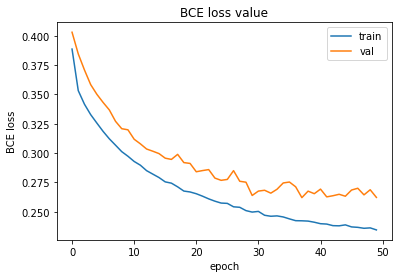

In [36]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

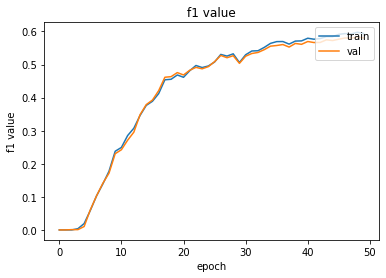

In [37]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [38]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ''.join([id2symbol[int(symbol)] for symbol in text if symbol !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [40]:
fp, fn, tp, tn = predict(model, val_iterator)

In [41]:
print('что правильно предсказываем:', tp[:100])

что правильно предсказываем: ['ГОЛЯМ', 'Андреевой', 'Лама', 'Калнауз', 'Сэндберг', 'Бакалинский', 'Франсом', 'Маркиным', 'ФАЙКОВОЙ', 'Сараджевой', 'Желобаева', 'Биат', 'Гречаниновнам', 'Лазарев', 'Холмс', 'Корчагин', 'Смик', 'Локвуде', 'Гришановым', 'Басков', 'Бартоны', 'Коростелев', 'Волынского', 'Вертковы', 'АБМАЙКИНА', 'Рябченко', 'Бафой', 'Богдановского', 'Бархударов', 'ШИМАНОВЫЙ', 'Бэром', 'Кричковська', 'Фролов', 'Хефнер', 'Гнеденко', 'Тимуркаевичах', 'Гебель', 'Ривас', 'Шкрябина', 'Завьялова', 'Ариасом', 'Лужина', 'Хофман', 'Булычев', 'Касперский', 'Рагинский', 'Комаровой', 'ЭБЕР', 'Башмачкиных', 'Гослинг', 'Мышковой', 'Кокачев', 'Ломова', 'Гайдер', 'Губанов', 'Линдеманах', 'Бараева', 'Буниной', 'Скоробагатый', 'Лебедев', 'Шкидченко', 'Фельдмана', 'Гирина', 'Лейка', 'Абдикалиевый', 'Бостону', 'Штайнера', 'Януковичу', 'Школенко', 'Малкина', 'Керимов', 'КАУКИН', 'Куйбышевских', 'Кайсаровым', 'Баха', 'Мендельсону', 'Калинина', 'Бойкову', 'Ломоносове', 'Шейфер', 'Гормана', 'Брене', 

In [42]:
print('ошибочно не относим к фамилиям:', fn[:100])

ошибочно не относим к фамилиям: ['Турки', 'Саммерса', 'КИРКА', 'Менделю', 'Кавендише', 'ИЛЬЧУК', 'Козодои', 'ПЛАНТ', 'ИВКА', 'ЧУПРИКОВА', 'Рае', 'риска', 'старт', 'Виде', 'АЛИСЕЕНКО', 'такер', 'ИНДЮШКИНАХ', 'Лацисом', 'ПЛЮТО', 'суярок', 'КОЛМОГОРОВА', 'кура', 'КИРИЛЕНКА', 'Локхартом', 'РОШ', 'КУЗНЕЦОВА', 'Твист', 'Рущаке', 'Кафтить', 'Сагрять', 'МАМБЕТЖАНОВ', 'Пога', 'ЯНУКОВИЧ', 'ОНЬКОВЫ', 'победители', 'САРИТОВЫЙ', 'Петерсону', 'АБУМ', 'Уруспаи', 'АГАГЮЛОВАМИ', 'Дурицыным', 'болван', 'ЧЕРЕДНИКОВ', 'алшоразовны', 'провалы', 'Остапенко', 'Дериземля', 'Ярмышеве', 'Кетрушенной', 'СЕНГЕРБАЕВНЫ', 'Мафедзовами', 'ДЖУСИПОВ', 'Стайне', 'Спарксе', 'Стокса', 'Дейку', 'ПОСКРЯКОВЫЙ', 'техника', 'Тхорёвая', 'врач', 'Давидкевичей', 'ВОЛЬЦМАНУ', 'мухамбеткалиев', 'Спрингер', 'Давлетхан', 'тезиковой', 'Ошана', 'МОНРО', 'Армстронгу', 'Оуэном', 'совет', 'Рихтером', 'Ищенко', 'СОТАЕВА', 'Абдулкадыр', 'Ливингстоне', 'Берию', 'современники', 'ДЗЬ', 'Пратасень', 'ГОВОРКОВЫХ', 'РОМАНКО', 'Михеля', 'генералы'

In [43]:
print('ошибочно считаем фамилиями:', fp[:100])

ошибочно считаем фамилиями: ['Колючек', 'Комарье', 'Камберленд', 'Каббалы', 'Раздевалка', 'Чечней', 'Зону', 'Гипюр', 'обычаев', 'Гроза', 'Тауэра', 'Клоуном', 'Волдыре', 'КИР', 'Линкольне', 'Васильевне', 'Гротон', 'Сэмсон', 'Ванну', 'Капернаум', 'Борису', 'Кивер', 'Самоварчик', 'Теологов', 'Роном', 'Аквариуму', 'Пектин', 'Шоферу', 'Грифель', 'Млрд', 'Человекам', 'Габоном', 'Валентиновича', 'Дней', 'Глашкой', 'СУБД', 'Рэма', 'Коуча', 'Лаша', 'Коронера', 'Биллингсе', 'Блудников', 'Чимборасо', 'РАНЧО', 'Ваза', 'Формулой', 'БАХРЕЙН', 'Серена', 'Мохамед', 'Гротона', 'Алабама', 'Фивы', 'Кочаны', 'Гисборна', 'Букраннерами', 'Халлибертона', 'Кухня', 'Комнатенка', 'ВИНА', 'Концерна', 'Разка', 'ЛИНДЕ', 'Браво', 'Хеврона', 'Аду', 'Клопов', 'Азербайджанцев', 'Арслан', 'Креп', 'Хишама', 'Линчберг', 'Бечевки', 'Филипповны', 'Государь', 'Айшу', 'Билла', 'Гонконге', 'Чтива', 'Челекен', 'Жаков', 'Хэллоуин', 'балдахинов', 'Рим', 'Арнольдович', 'Траву', 'Шабатом', 'Корнелиусу', 'Катангу', 'ТЯГАЧ', 'Парча'